In [1]:
#| default_exp benchmarking

In [2]:
#| export
import matplotlib.pyplot as plt
import numpy as np


def plot_lines(protvals, log = True):
    """plot peptide profiles for a protein"""
    colors = plt.cm.tab20c(np.linspace(0,1,protvals.shape[0]))
    #cmap = plt.get_cmap("tab20c")
    idx = 0
    for row in protvals:
        if not log:
            row = 2**row
        plt.plot(row, c= colors[idx])
        idx+=1
    median_row = np.nanmedian(protvals, axis=0)
    print(median_row)
    plt.plot(median_row, c = 'black',linewidth =3 )
    plt.show()

def plot_points(protvals, log = True):
    colors = plt.cm.tab20c(np.linspace(0,1,protvals.shape[0]))
    #cmap = plt.get_cmap("tab20c")
    idx = 0
    for row in protvals:
        if not log:
            row = 2**row
        x_coord = list(range(len(row)))
        plt.scatter(x_coord,row, c= colors[idx])
        idx+=1

    plt.show()

In [3]:
#| export
import pandas as pd
def get_tps_fps(result_df, prot2org_file, thresh = 0.05, fc_thresh = 0.3):
    annotated = annotate_dataframe(result_df, prot2org_file)
    condpairs = result_df["condpair"].drop_duplicates()


    for condpair in condpairs:
        annotated_condpair = annotated[annotated["condpair"]==condpair]
        num_tps = sum(annotated_condpair["TP"])
        num_fps = sum(annotated_condpair["FP"])
        annotated_fcfilt = annotated_condpair[annotated["log2fc"] >fc_thresh]
        num_regulated_prots = sum(annotated_fcfilt["fdr"]<thresh)
        num_true_positives = sum(annotated_fcfilt["TP"] &(annotated_fcfilt["fdr"]<0.05))
        num_false_positives = sum(annotated_fcfilt["FP"] &(annotated_fcfilt["fdr"]<0.05))
        fpr = num_false_positives/num_regulated_prots

        print(f'condpair {condpair}')
        print(f"total TPs {num_tps}")
        print(f"total FPs {num_fps}")
        print(f'regulated {num_regulated_prots}')
        print(f'false positives {num_false_positives}')
        print(f'true positives {num_true_positives}')
        print(f'regulated control {num_false_positives+num_true_positives}')
        print(f'FPR {fpr}')

        assert fpr < 0.06


def annotate_dataframe(result_df, prot2org_file):
    prot2org = pd.read_csv(prot2org_file, sep = "\t")
    prot2org["FP"] = (prot2org["organism"] == "Homo sapiens")
    prot2org["TP"] = (prot2org["organism"] == "Saccharomyces cerevisiae")
    prot2org = prot2org[(prot2org["FP"] | prot2org["TP"])]
    print(f"df size before {len(result_df.index)}")
    annotated = pd.merge(result_df, prot2org, how='inner', on = "protein")
    print(f"df size after {len(annotated.index)}")
    return annotated

In [4]:
#| export
import pandas as pd
import matplotlib.pyplot as plt
def compare_to_reference(result_df, reference_file, condpair):#put in condpair as tuple
    result_df = result_df[result_df["condpair"]==condpair]

    ref_df = pd.read_csv(reference_file, sep = "\t")
    merged = pd.merge(result_df, ref_df, how='inner', on = "protein",suffixes = ["", "_ref"])
    ax_p = merged.plot.scatter(x='pval_ref',y='pval')
    plt.show()
    ax_fc = merged.plot.scatter(x='log2FC_ref',y='fc')
    plt.show()
    ax_fdr = merged.plot.scatter(x='fdr_ref',y='fdr')
    plt.show()

In [5]:
#| export
import pandas as pd
import matplotlib.pyplot as plt
def compare_normalization(ref_normalization_file, norm1_df, norm2_df):
    ref_normed = pd.read_csv(ref_normalization_file, sep ="\t").set_index('peptide')

    merged = pd.merge(norm1_df, norm2_df, how='inner',  left_index = True, right_index = True)
    columns = merged.columns
    merged = pd.merge(ref_normed, merged, how='inner', left_index = True, right_index = True, suffixes = ["_ref", ""])

    for i in range(len(columns)):
        sample1 = columns[i]
        sample2 = sample1+"_ref"
        ax_p = merged.plot.scatter(x=sample1,y=sample2)
        plt.show()

In [6]:
#| export
def print_nonref_hits(protein_ref, protein_df, peptide_ref, peptide_df, outdir):
    prots_nonref_df =  protein_df[~(protein_df["protein"].isin(protein_ref["protein"].to_list()))]#the tilde inverts the boolean vector
    peps_nonref_df = peptide_df[~(peptide_df["peptide"].isin(peptide_ref["peptide"].to_list()))]
    prots_nonref_df.to_csv(f"{outdir}/nonref_proteins.tsv", sep = "\t", index = False)
    peps_nonref_df.to_csv(f"{outdir}/nonref_peptides.tsv", sep = "\t", index = False)
    #display(peps_nonref_df)

### Results Tables

In [7]:
#| export
import pandas as pd
import functools


class ResultsTable():
    def __init__(self, input_file, input_name):
        self._input_file = input_file
        self._samples_c1 = None
        self._samples_c2 = None
        self.input_name = input_name
        self.protein_column = "protein"
        self.organism_column = "organism"
        self.log2fc_column = 'log2fc'
        self.mean_intensity_column = 'mean_intensity'
        self.formated_dataframe = None

    
    def get_proteins(self):
        return self.formated_dataframe[self.protein_column]

    def _add_mean_intensity_column(self):
        self._add_median_intensity_columns_for_each_condition()
        self.formated_dataframe[self.mean_intensity_column] = self.formated_dataframe[['median_intensity_c1', 'median_intensity_c2']].mean(axis = 1)

    
    def _add_median_intensity_columns_for_each_condition(self):
        self.formated_dataframe['median_intensity_c1'] = self.formated_dataframe[self._samples_c1].median(axis =1)
        self.formated_dataframe['median_intensity_c2'] = self.formated_dataframe[self._samples_c2].median(axis =1)

    def _add_log2fc_column(self):
        self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]




class ResultsTableDirectLFQ(ResultsTable):
    def __init__(self, input_file, input_name,  samples_c1, samples_c2):
        super().__init__(input_file, input_name)
        self._samples_c1 = samples_c1
        self._samples_c2 = samples_c2
        self._define_formatted_dataframe()
        
    def _define_formatted_dataframe(self):
        self._load_directlfq_output()
        self._add_median_intensity_columns_for_each_condition()
        self._add_log2fc_column()
        self._add_mean_intensity_column()
        
    def _load_directlfq_output(self):
        self.formated_dataframe =  pd.read_csv(self._input_file, sep = "\t")


class ResultsTableIq(ResultsTable):
    def __init__(self, input_file, input_name,  samples_c1, samples_c2):
        super().__init__(input_file, input_name)
        self._samples_c1 = samples_c1
        self._samples_c2 = samples_c2
        self._define_formatted_dataframe()
        
    def _define_formatted_dataframe(self):
        self._load_directlfq_output()
        self.formated_dataframe[self._samples_c1+self._samples_c2] = 2**self.formated_dataframe[self._samples_c1 + self._samples_c2]
        self._add_median_intensity_columns_for_each_condition()
        self._add_log2fc_column()
        self._add_mean_intensity_column()
        
    def _load_directlfq_output(self):
        self.formated_dataframe =  pd.read_csv(self._input_file, sep = "\t")




class ResultsTableMaxQuant(ResultsTable):
    def __init__(self, input_file, input_name,  samples_c1, samples_c2):
        super().__init__(input_file, input_name)
        self._samples_c1 = samples_c1
        self._samples_c2 = samples_c2
        self._define_formatted_dataframe()

    
    def _define_formatted_dataframe(self):
        self._load_maxquant_output()
        self._add_median_intensity_columns_for_each_condition()
        self._add_log2fc_column()
        self._add_mean_intensity_column()

    def _load_maxquant_output(self):
        columns_to_use = self._samples_c1 + self._samples_c2 + ["Protein IDs"]
        self.formated_dataframe = pd.read_csv(self._input_file, sep = "\t", usecols=columns_to_use)
        self.formated_dataframe = self.formated_dataframe.rename({'Protein IDs':self.protein_column},axis=1)



In [8]:
#| export
class ResultsTableMerger():
    def __init__(self, method_name2results_df):
        self._method_name2results_df = method_name2results_df
        self._list_of_tables = []

        self.merged_table = None

        self._define_merged_table()

    def _define_merged_table(self):
        self._collect_list_of_annotated_tables()
        self.merged_table = pd.concat(self._list_of_tables)
        self._filter_merged_table_for_valid_fcs()
    
    def _collect_list_of_annotated_tables(self):
        for method, df in self._method_name2results_df.items():
            self._add_method_column(method, df)
            self._list_of_tables.append(df)

    def _filter_merged_table_for_valid_fcs(self):
        is_valid = [np.isfinite(x) for x in self.merged_table["log2fc"]]
        self.merged_table = self.merged_table[is_valid]

    @staticmethod
    def _add_method_column(method, df):
        df["method"] = method

### Organism Annotation

In [9]:
#| export
from abc import ABC, abstractmethod

class OrganismAnnotator(ABC):
    def __init__(self, mapping_file, protein_column = 'id', organism_column = 'Species'):
        self._mapping_file = mapping_file
        self._protein_column = protein_column
        self._organism_column = organism_column
        self._protein_organism_mapping_df = self._load_reduce_mapping_dataframe()
        super().__init__()

    def annotate_table_with_organism(self, results_table):

        self.__add_organism_column_to_results_table(results_table)
        self.__filter_non_matching_proteins(results_table)
        

    def save_protein_organism_map(self, outfile):
        self._protein_organism_mapping_df.to_csv(outfile, sep = "\t", index = None)
    
    @abstractmethod
    def _load_reduce_mapping_dataframe(self):
        pass
    
    def _filter_double_mapping_organism(self, protein2organism_df):
        protein2organism_df = protein2organism_df[[";" not in x for x in protein2organism_df[self._organism_column].astype('str')]] #a semicolon seperates different organism entries
        return protein2organism_df

    def __add_organism_column_to_results_table(self, results_table):
        protein2organism_dict = self.__get_protein2organism_dict()
        proteins_resultstable = results_table.formated_dataframe[results_table.protein_column].astype('str')
        results_table.formated_dataframe[results_table.organism_column] = [protein2organism_dict.get(x) for x in proteins_resultstable]

    def __get_protein2organism_dict(self):
        protein2organism = dict(zip(self._protein_organism_mapping_df[self._protein_column].astype('str'), self._protein_organism_mapping_df[self._organism_column]))
        return protein2organism
    
    @staticmethod
    def __filter_non_matching_proteins(results_table):
        list_indicating_if_protein_matches = [x is not None for x in results_table.formated_dataframe[results_table.organism_column]]
        results_table.formated_dataframe = results_table.formated_dataframe[list_indicating_if_protein_matches]
        

In [10]:
#| export
class OrganismAnnotatorMaxQuant(OrganismAnnotator):
    def __init__(self, mapping_file, protein_column = 'id', organism_column = 'Species'):
        super().__init__(mapping_file=mapping_file, protein_column= protein_column, organism_column= organism_column)
    
    def _load_reduce_mapping_dataframe(self):
        mapping_df = pd.read_csv(self._mapping_file, sep = "\t", usecols=[self._protein_column, self._organism_column], encoding='latin1').drop_duplicates()
        mapping_df = self._filter_double_mapping_organism(mapping_df)
        return mapping_df

In [11]:
#| export
class OrganismAnnotatorSpectronaut(OrganismAnnotator):
    def __init__(self, mapping_file,protein_column="PG.ProteinGroups", organism_column="PG.Organisms"):
        super().__init__(mapping_file=mapping_file, protein_column= protein_column, organism_column= organism_column)
    
    def _load_reduce_mapping_dataframe(self):
        mapping_df = pd.read_csv(self._mapping_file, sep = "\t", usecols=[self._protein_column, self._organism_column], encoding='latin1').drop_duplicates()
        mapping_df = self._filter_double_mapping_organism(mapping_df)
        return mapping_df

In [12]:
#| export
class OrganismAnnotatorDIANN(OrganismAnnotator):
    def __init__(self, mapping_file, protein_column = 'Protein.Group', organism_column = 'Protein.Names'):
        super().__init__(mapping_file=mapping_file, protein_column= protein_column, organism_column= organism_column)
    
    def _load_reduce_mapping_dataframe(self):
        mapping_df = pd.read_csv(self._mapping_file, sep = "\t", usecols=[self._protein_column, self._organism_column], encoding='latin1').drop_duplicates()
        mapping_df[self._organism_column] = [self.__get_organism_from_protein_name(x) for x in mapping_df[self._organism_column]]
        mapping_df = mapping_df.drop_duplicates()
        return mapping_df
    
    @staticmethod
    def __get_organism_from_protein_name(protein_name):
        split_name = protein_name.split("_")
        if len(split_name) <2:
            return "None"
        else:
            return split_name[-1]

In [13]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import directlfq.visualizations as lfq_viz


class PlotConfig():
    def __init__(self, x_axisboundaries = None, y_axisboundaries = None, colormaps = None):
        self.x_axisboundaries = x_axisboundaries
        self.y_axisboundaries = y_axisboundaries
        self._colormaps = colormaps

class MultiOrganismIntensityFCPlotter():
    def __init__(self, ax, resultstable_w_ratios, organisms_to_plot = None, fcs_to_expect = None, title = ""):
        self.ax = ax
        self._color_scheme = lfq_viz.AlphaPeptColorMap()
        self._resultstable_w_ratios = resultstable_w_ratios
        self._organism_column = resultstable_w_ratios.organism_column
        self._log2fc_column = resultstable_w_ratios.log2fc_column
        self._mean_intensity_column = resultstable_w_ratios.mean_intensity_column
        
        self._organisms_to_plot = self._get_organisms_to_plot(organisms_to_plot)
        self._fcs_to_expect = fcs_to_expect

        self._title = self._get_title(title)
        self._scatter_per_organism()
        self._add_expected_lines()

    def _get_organisms_to_plot(self, organisms_to_plot):
        if organisms_to_plot is not None:
            return organisms_to_plot
        else:
            return sorted(list(set(self._resultstable_w_ratios.formated_dataframe[self._organism_column].astype('str'))))
    
    def _get_title(self, title):
        if title !="":
            self._print_infos_about_data()
            return title
        return self._generate_title()

    def _print_infos_about_data(self):
        for organism in self._organisms_to_plot:
            subtable_organism = self._get_organism_subtable(organism)
            print(self._get_stats_of_organism(organism, subtable_organism))

    def _generate_title(self):
        for organism in self._organisms_to_plot:
            subtable_organism = self._get_organism_subtable(organism)
            title += self._get_stats_of_organism(organism, subtable_organism)
        return title

    def _scatter_per_organism(self):
        complete_table = self._resultstable_w_ratios.formated_dataframe.copy()
        complete_table[self._mean_intensity_column] = np.log2(complete_table[self._mean_intensity_column])
        complete_table = self._remove_omitted_organisms_from_table(complete_table)
        color_palette = sns.color_palette(self._color_scheme.colorlist_hex, n_colors=len(self._organisms_to_plot))
        sns.scatterplot(data= complete_table, x =self._mean_intensity_column, y= self._log2fc_column, hue=self._organism_column, alpha=0.15, ax=self.ax, 
        hue_order=self._organisms_to_plot, palette=color_palette, size=0.2)
        self.ax.set_title(self._title)
    
    def _remove_omitted_organisms_from_table(self, complete_table):
        row_w_permitted_organism = [x in self._organisms_to_plot for x in complete_table["organism"]]
        return complete_table[row_w_permitted_organism]

    def _add_expected_lines(self):
        if self._fcs_to_expect is not None:
            for idx, fc in enumerate(self._fcs_to_expect):
                color = self._color_scheme.colorlist[idx]
                self.ax.axhline(fc, color = color)

    def _get_organism_subtable(self, organism):
        complete_table = self._resultstable_w_ratios.formated_dataframe
        return complete_table[complete_table[self._organism_column] == organism]
    
    def _get_stats_of_organism(self, organism, subtable_organism):
        fcs = subtable_organism[self._log2fc_column].to_numpy()
        fcs = fcs[np.isfinite(fcs)]
        median_fc = np.nanmedian(fcs)
        std_fc = np.nanstd(fcs)
        num_ratios = sum(~np.isnan(fcs))
        return f"{organism} num:{num_ratios} median_FC:{median_fc:.2} STD:{std_fc:.2}\n"
 

### Obtain CV distribution from ProteinIntensityTable

In [14]:
#| export
import pandas as pd
import directlfq.utils as lfq_utils

class ResultsTableBiological():
    def __init__(self, results_file, samplemap, name, protein_id = "protein"):
        self._results_file = results_file
        self._samplemap = samplemap
        self._protein_id = protein_id
        
        self.name = name


        self.results_df = None
        self.cond2samples = {}

        self._load_results_table()
        self._load_cond2samples()

    def _load_results_table(self):
        self.results_df = pd.read_csv(self._results_file, sep = "\t")
        self.results_df = self.results_df[[not x.startswith("REV_") and not x.startswith("CON_") for x in self.results_df[self._protein_id].astype('str')]]
        self.results_df = self.results_df.replace(0, np.nan)
    
    def _load_cond2samples(self):
        samplemap_df = lfq_utils.load_samplemap(self._samplemap)
        for sample, cond in zip(samplemap_df["sample"], samplemap_df["condition"]):
            self.cond2samples[cond] = self.cond2samples.get(cond, []) + [sample]
    

In [15]:
#| export
import numpy as np
class CVInfoDataset():
    def __init__(self, resultstable_biological, ignore_missing_columns = False):
        self._results_table = resultstable_biological
        self._ignore_missing_columns = ignore_missing_columns
        
        self.name = resultstable_biological.name
        self.cvs = []


        self._calculate_cvs()

    def _calculate_cvs(self):
        for samples in self._results_table.cond2samples.values():
            if self._ignore_missing_columns:
                samples = self._reduce_samples_to_existing_columns(samples)
            self._add_protein_cvs_for_condition(samples)
    
    def _reduce_samples_to_existing_columns(self, samples):
        existing_columns = [x for x in samples if x in self._results_table.results_df.columns]
        return existing_columns

    def _add_protein_cvs_for_condition(self, samples):
        subtable = self._results_table.results_df[samples]
        protein_cvs = subtable.apply(self._cv_function,axis = 1)
        protein_cvs = [x for x in protein_cvs if not np.isnan(x)]
        self.cvs += list(protein_cvs)

    @staticmethod
    def _cv_function(x):
        x = x.to_numpy()
        if sum(~np.isnan(x)) <2:
            return np.nan
        return np.nanstd(x, ddof=1,) / np.nanmean(x) ##ddof ensures that the sample mean std estimate is used

In [16]:
#| export
import seaborn as sns
import directlfq.visualizations as lfq_viz
class CVDistributionPlotter():
    def __init__(self, list_of_dataset_cv_infos, ax, cumulative=False, histtype='step', density=False, bins=150):
        self._histconfig = HistPlotConfig(cumulative, histtype, density, bins)
        self._list_of_dataset_cv_infos = list_of_dataset_cv_infos
        self._ax  = ax
        self._plot_histograms()

    def _plot_histograms(self):
        self._ax.set_prop_cycle(color = lfq_viz.AlphaPeptColorMap().colorlist_hex)
        for dataset_cv_info in self._list_of_dataset_cv_infos:
            self._add_cv_histogram(dataset_cv_info)

    def _add_cv_histogram(self, dataset_cv_info):
        cvs = dataset_cv_info.cvs
        all_cvs = len(cvs)
        cvs = [x for x in cvs if x<0.75]
        print(f"{all_cvs - len(cvs)} are very large for {dataset_cv_info.name}")
        print(len(cvs))
        print(np.nanmean(cvs))
        print(np.nanmedian(cvs))
        labelname = f"{dataset_cv_info.name} ({all_cvs})"
        color = next(self._ax._get_lines.prop_cycler)["color"]
        self._ax.hist(cvs, label=labelname, cumulative=self._histconfig.cumulative, histtype='stepfilled', density=self._histconfig.density, bins=self._histconfig.bins, linewidth = 1.5, alpha = 0.5, color = color)
        self._ax.hist(cvs, cumulative=self._histconfig.cumulative, histtype='step', density=self._histconfig.density, bins=self._histconfig.bins, linewidth = 1.5, color = color, edgecolor = color)
      

class HistPlotConfig():
    def __init__(self,  cumulative, histtype, density, bins):
        self.cumulative = cumulative
        self.histtype = histtype
        self.density = density
        self.bins = bins

### Test CV distribution estimation

In [17]:
#| include: false

class ResTableTest(ResultsTableBiological):
    def __init__(self):
        pass
def test_cv_estimation():
    restable_test = ResTableTest()
    restable_test.name = "name"
    restable_test.cond2samples = {"cond" : ['A', 'B'], "othercond" : ['A', 'C']}
    restable_test.results_df = pd.DataFrame({'A' : [1, 2, 3], 'B' : [1, 2, 3], 'C' : [3, 2, 1]})
    calced_cvs = CVInfoDataset(restable_test).cvs
    assert np.allclose([0.0, 0.0, 0.0, 0.7071067811865476, 0.0, 0.7071067811865476], calced_cvs)

test_cv_estimation()

683 are very large for diann
24479
0.16439435548041562
0.08925015127956025


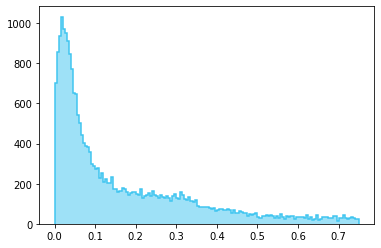

In [18]:
import matplotlib.pyplot as plt
input_file = "../test_data/system_tests/lfqbench/DIANN/report.tsv.diann_fragion_isotopes_raw.aq_reformat.tsv.protein_intensities.tsv"
samplemap_file = "../test_data/system_tests/lfqbench/DIANN/samplemap.tsv"

biol_res = ResultsTableBiological(results_file=input_file, samplemap=samplemap_file, name="diann")
biol_res.cond2samples
biol_res.results_df

calced_cvs = CVInfoDataset(biol_res)
ax = plt.subplot()
CVDistributionPlotter([calced_cvs], ax=ax)
plt.show()

### Create input dataframes with scalable number of samples

In [19]:
#| export
import pandas as pd
import directlfq.lfq_manager as lfqmgr
import directlfq.normalization as lfqnorm
import directlfq.protein_intensity_estimation as lfq_protein_estimation
import time
import math


class SampleListScaler():
    def __init__(self, sample_list, desired_number_of_samples):
        self._sample_list = sample_list
        self._desired_number_of_samples = desired_number_of_samples
        
        self.num_replicates_of_sample_list = None
        self.num_remaining_samples = None

        self.scaled_sample_list = []
        self._define_scaled_sample_list()

    def _define_scaled_sample_list(self):
        self._define_number_of_replicates_of_samples()
        self._define_number_of_remaining_samples()
        self._append_replicate_sample_names_to_scaled_sample_list()
        self._append_remaining_sample_names_to_scaled_sample_list()

    def _define_number_of_replicates_of_samples(self):
        num_samples_in_df = len(self._sample_list)
        self.num_replicates_of_sample_list = math.floor(self._desired_number_of_samples/num_samples_in_df)
    
    def _define_number_of_remaining_samples(self):
        num_samples_in_df = len(self._sample_list)
        self.num_remaining_samples = self._desired_number_of_samples%num_samples_in_df

    def _append_replicate_sample_names_to_scaled_sample_list(self):
        for idx in range(self.num_replicates_of_sample_list):
            self.scaled_sample_list += [f"{x}_AND_{idx}" for x in self._sample_list]

    def _append_remaining_sample_names_to_scaled_sample_list(self):
        self.scaled_sample_list +=[f"{self._sample_list[x]}_AND_remainder" for x in range(self.num_remaining_samples)]

    @staticmethod
    def get_original_sample_name(new_sample_name):
        return new_sample_name.split("_AND_")[0]


class SampleIndexIQScaler(SampleListScaler):
    def __init__(self, sample_index_list, desired_number_of_samples):
        self._sample_list = sample_index_list
        self._desired_number_of_samples = desired_number_of_samples
        self.scaled_sample_list = []
        
    def _append_replicate_sample_names_to_scaled_sample_list(self):
        for idx in range(self._num_replicates_of_sample_list):
            offset_to_zero_idx = len(set(self._sample_list))*idx
            self.scaled_sample_list += [ x + offset_to_zero_idx for x in self._sample_list]

    def _append_remaining_sample_names_to_scaled_sample_list(self):
        offset_to_zero_idx = self.scaled_sample_list[-1]+1
        self.scaled_sample_list +=[x + offset_to_zero_idx for x in range(self._num_remaining_samples)]


class ScaledDFCreatorDirectLFQFormat():
    def __init__(self, template_df, desired_number_of_samples):
        self._template_df = template_df
        self._column_names = list(self._template_df.columns)
        self._samplelist_scaler = SampleListScaler(self._column_names, desired_number_of_samples)         
        self.scaled_df = None
        self._create_scaled_dataframe()

    def _create_scaled_dataframe(self):
        template_dataframe_dict = self._template_df.to_dict(orient = 'list')
        input_dataframe_dict = {x : template_dataframe_dict.get(self._samplelist_scaler.get_original_sample_name(x))  for x in self._samplelist_scaler.scaled_sample_list}
        self.scaled_df = pd.DataFrame(input_dataframe_dict, index=self._template_df.index)


from io import BytesIO
from csv import writer 
import pandas as pd

class ScaledDFCreatorIQFormat():
    def __init__(self, quant_df, sample_list_df, desired_number_of_samples):
        self._quant_df = quant_df
        self._sample_list = sample_list_df["sample_list"]
        self._desired_number_of_samples = desired_number_of_samples
        self._samplelist_scaler = None

        self.scaled_quant_df = None

        self._create_scaled_quant_df()
        self._create_scaled_sample_list_df()

    def _create_scaled_quant_df(self):
        self._create_indexes_to_expand_quant_df()
        self._quant_df = self._quant_df.set_index("sample_list")#.loc[self._indexes_to_expand_quant_df]
        
        self.scaled_quant_df = self._get_scaled_quant_df(self._indexes_to_expand_quant_df)
        self.scaled_quant_df["sample_list"] = self._get_new_samples_column()
        self.scaled_quant_df = self.scaled_quant_df.reset_index(drop= True)

    def _get_scaled_quant_df(self, indexes):
        list_of_sub_dfs = []
        for idx in indexes:
            rows = pd.DataFrame(self._quant_df.loc[[idx]])
            list_of_sub_dfs.append(rows)

        return pd.concat(list_of_sub_dfs)

    def _create_scaled_sample_list_df(self):
        self._samplelist_scaler = SampleListScaler(sample_list = self._sample_list, desired_number_of_samples= len(set(self.scaled_quant_df["sample_list"])))
        self.scaled_sample_list_df = pd.DataFrame({"sample_list" : self._samplelist_scaler.scaled_sample_list})

    def _create_indexes_to_expand_quant_df(self):
        num_scaled_samples = self._desired_number_of_samples
        num_samples = len(self._sample_list)
        indexes_of_scaled_sample_list = list(range(num_scaled_samples))
        self._indexes_to_expand_quant_df = [x%num_samples+1 for x in indexes_of_scaled_sample_list]

    def _get_new_samples_column(self):
        scaled_repeated_sample_list = self.scaled_quant_df.index
        previous_sample = scaled_repeated_sample_list[0]
        new_sample_list = [1]

        sample_id = 1
        for sample in scaled_repeated_sample_list[1:]:
            if sample != previous_sample:
                sample_id +=1
                previous_sample = sample
            new_sample_list.append(sample_id)
            
        return new_sample_list
    

### Test input df creation

In [20]:
#| include: false
import numpy as np
import pandas as pd

quant_df  = pd.DataFrame({'sample_list' : [1, 1, 1, 2, 2, 2, 3], 'asd' : ['a', 'b', 'c', 'd', 'e', 'f', 'g'], 'cfs' : [11, 23, 4, 5, 7, 4, 9]})
samplelist_df = pd.DataFrame({'sample_list' : ['s1', 's2', 's3']})

def test_that_scaled_numbers_of_samples_are_as_expected(quant_df, samplelist_df,desired_num_samples):    
    scaled_df_creator = ScaledDFCreatorIQFormat(quant_df, samplelist_df, desired_num_samples)
    assert len(set(scaled_df_creator.scaled_quant_df["sample_list"])) == desired_num_samples
    assert len(scaled_df_creator.scaled_sample_list_df.index) == desired_num_samples


test_that_scaled_numbers_of_samples_are_as_expected(quant_df, samplelist_df, 1)
test_that_scaled_numbers_of_samples_are_as_expected(quant_df, samplelist_df, 7)
test_that_scaled_numbers_of_samples_are_as_expected(quant_df, samplelist_df, 13)


def test_that_repetition_worked_out(quant_df, samplelist_df):
    scaled_df_creator = ScaledDFCreatorIQFormat(quant_df, samplelist_df, 7)
    assert np.alltrue(scaled_df_creator.scaled_quant_df["sample_list"][6] == [3])

test_that_repetition_worked_out(quant_df, samplelist_df)

In [21]:
#| include: false
import pandas as pd
import numpy as np
class TemplateDFCreator():
    def __init__(self):

        self.template_df = None
        self._template_df_location = "../test_data/unit_tests/protein_normalization/example_proteins.tsv"
        self._create_template_df()

    def _create_template_df(self):
        self.template_df = pd.read_csv(self._template_df_location, index_col= ["protein", "ion"], sep = "\t")


def test_that_shape_is_as_expected(num_samples):
    template_df = TemplateDFCreator().template_df
    size_adjusted_df = ScaledDFCreatorDirectLFQFormat(template_df=template_df, desired_number_of_samples= num_samples).scaled_df
    assert len(size_adjusted_df.columns) == num_samples
    assert len(size_adjusted_df.index) == len(template_df.index)
    print("performed_checks")


test_that_shape_is_as_expected(1)
test_that_shape_is_as_expected(100)
test_that_shape_is_as_expected(10000)

def test_that_values_are_as_expected(num_samples):
    template_df = TemplateDFCreator().template_df
    size_adjusted_df = ScaledDFCreatorDirectLFQFormat(template_df=template_df, desired_number_of_samples= num_samples).scaled_df
    assert np.allclose(template_df.loc[:,"BoxCar_02-01_2"], size_adjusted_df.loc[:, "BoxCar_02-01_2_AND_remainder"])


test_that_values_are_as_expected(5)
test_that_values_are_as_expected(100)


performed_checks
performed_checks
performed_checks


In [22]:
#| export
import pandas as pd
import directlfq.utils as lfq_utils

class LFQTimer():
    def __init__(self, template_file, list_of_samplenumbers_to_check, name):
        self._template_file = template_file
        self._samplenumbers_to_check = list_of_samplenumbers_to_check
        self._name = name
        self._template_df = None
        self._read_template_file()
        self.timed_lfq_runs = []
        self._iterate_through_sizes()
    
    def _read_template_file(self):
        self._template_df = pd.read_csv(self._template_file, sep = "\t")
        self._template_df = lfq_utils.index_and_log_transform_input_df(self._template_df)

    def _iterate_through_sizes(self):
        for samplenumber in self._samplenumbers_to_check:
            formatted_df = ScaledDFCreatorDirectLFQFormat(self._template_df, desired_number_of_samples=samplenumber).scaled_df
            self.timed_lfq_runs.append(TimedLFQRun(formatted_df,self._name).run_from_formatted_df())

In [23]:
#| export        

class TimedLFQRun():
    def __init__(self, formatted_df, name):
        self.name = name
        self.runtime_info = RuntimeInfo()
        self.num_samples = len(formatted_df.columns)
        self._formatted_df = formatted_df

    def run_from_formatted_df(self):
        self.runtime_info._start_samplenorm = time.time()
        input_df_normed = lfqnorm.NormalizationManagerSamples(self._formatted_df, num_samples_quadratic=50).complete_dataframe
        self.runtime_info._end_samplenorm = time.time()
        self.runtime_info._start_protein_norm = time.time()
        lfq_protein_estimation.estimate_protein_intensities(input_df_normed,min_nonan=1, num_samples_quadratic=10, num_cores=None)
        self.runtime_info._end_protein_norm = time.time()
        self.runtime_info.calculate_runtimes()
        return self

class RuntimeInfo():
    def __init__(self):
        self._start_samplenorm= None
        self._end_samplenorm = None
        self._start_protein_norm = None
        self._end_protein_norm = None

        self.overall_runtime = None
        self.runtime_samplenorm = None
        self.runtime_protein_norm = None

    def calculate_runtimes(self):
        self.overall_runtime = (self._end_protein_norm - self._start_samplenorm)/60
        self.runtime_samplenorm = (self._end_samplenorm - self._start_samplenorm)/60
        self.runtime_protein_norm = (self._end_protein_norm - self._start_protein_norm)/60

### Learning Tests

In [24]:
import seaborn as sns
import numpy as np


def check_taking_mean_of_pandas_columns():
    df = sns.load_dataset('iris')
    display(df)
    df.iloc[3:6, 1] = np.nan
    display(df)
    df['mean_sepal_width_petal_length'] = df[["sepal_width", "petal_length"]].median(axis = 1, skipna = True)
    assert df.loc[3, 'mean_sepal_width_petal_length'] == df.loc[3, 'petal_length']


check_taking_mean_of_pandas_columns()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,NaN,1.5,0.2,setosa
4,5.0,NaN,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
def check_cv_calculation_along_a_dataframe_axis():
        
    df_test = sns.load_dataset("iris").drop(labels = "species", axis = 1)
    cv_function = lambda x: np.std(x, ddof=1,) / np.mean(x)
    cv_results = df_test.apply(cv_function, axis=1)
    display(df_test)
    display(cv_results)

/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


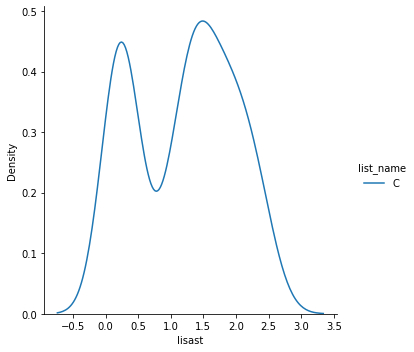

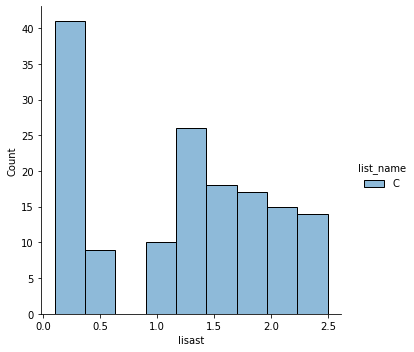

In [26]:
import pandas as pd
import seaborn as sns

def check_denisty_plot(kind):
    df_data = sns.load_dataset("iris")
    arr1 = list(df_data["sepal_length"])
    arr2 = list(df_data["petal_length"])
    arr3 = list(df_data["petal_width"])
    df_1 = create_df_for_list(arr1, "A")
    df_2 = create_df_for_list(arr2, "B")
    df_3 = create_df_for_list(arr3, "C")
    #df_merged = pd.concat([df_1, df_2, df_3]).reset_index()
    df_merged = pd.concat([df_3]).reset_index()
    sns.displot(data=df_merged, x='lisast',hue='list_name', kind=kind)


def create_df_for_list(list, list_name):
    df = pd.DataFrame({'lisast' : list})
    df['list_name'] = list_name
    return df

check_denisty_plot('kde')
check_denisty_plot('hist')
